In [1]:
%load_ext autoreload
%autoreload 2

# Load EMA weights

In [2]:
from pathlib import Path
from omegaconf import OmegaConf

import torch
from plaid.diffusion import FunctionOrganismDiffusion
from plaid.denoisers import FunctionOrganismDiT, DenoiserKwargs
from plaid.constants import COMPRESSION_INPUT_DIMENSIONS, COMPRESSION_SHORTEN_FACTORS

In [3]:
model_id = "dojwljt5"

ckpt_dir = Path("/data/lux70/plaid/checkpoints/plaid_compositional_conditioning") 
model_path = ckpt_dir / model_id / "last.ckpt"
config_path = ckpt_dir / model_id / "config.yaml"

cfg = OmegaConf.load("/data/lux70/plaid/checkpoints/plaid_compositional_conditioning/dojwljt5/config.yaml")

In [4]:
compression_model_id = cfg['compression_model_id']
shorten_factor = COMPRESSION_SHORTEN_FACTORS[compression_model_id]
input_dim = COMPRESSION_INPUT_DIMENSIONS[compression_model_id]

In [5]:
denoiser_kwargs = cfg.denoiser
denoiser_kwargs.pop("_target_")

diffusion_kwargs = cfg.diffusion
diffusion_kwargs.pop("_target_")

'plaid.diffusion.FunctionOrganismDiffusion'

In [6]:
denoiser = FunctionOrganismDiT(**denoiser_kwargs, input_dim=input_dim)
diffusion = FunctionOrganismDiffusion(**diffusion_kwargs, model=denoiser)

line 87

Number of visible CUDA GPUs: 1
Current GPU ID device number: 0
Current CUDA memory allocated: 0.0 MB
Current CUDA memory reserved: 0.0 MB
Number of visible CPUs: 8

line 94

Number of visible CUDA GPUs: 1
Current GPU ID device number: 0
Current CUDA memory allocated: 0.0 MB
Current CUDA memory reserved: 0.0 MB
Number of visible CPUs: 8

line 108

Number of visible CUDA GPUs: 1
Current GPU ID device number: 0
Current CUDA memory allocated: 0.0 MB
Current CUDA memory reserved: 0.0 MB
Number of visible CPUs: 8



In [7]:
ckpt = torch.load(model_path)
# ckpt.keys()

In [8]:
ckpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters', 'ema_state_dict'])

In [9]:
diffusion.model.load_state_dict(ckpt['state_dict'])
diffusion.ema_model.load_state_dict(ckpt['ema_state_dict'])
_ = diffusion.eval().requires_grad_(False)

# Organize Conditioning Classes

In [10]:
import pandas as pd

go_metadata_fpath = "/data/lux70/data/pfam/pfam2go.csv"
organism_metadata_fpath = "/data/lux70/data/pfam/organism_counts.csv"

go_df = pd.read_csv(go_metadata_fpath)
org_df = pd.read_csv(organism_metadata_fpath)

go_counts = pd.read_csv("/data/lux70/data/pfam/go_counts.csv")

In [11]:
# tmp = go_df.groupby("GO_term").first().reset_index().sort_values("GO_idx")

In [12]:
go_idx_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
go_idx_df

,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,GO_idx
0,161,G protein-coupled receptor activity,PF00001,GO:0004930,function,11,0
1,54,ATP hydrolysis activity,PF00004,GO:0016887,function,15,1
2,52,ATP binding,PF00006,GO:0005524,function,178,2
3,174,GTPase activity,PF00009,GO:0003924,function,10,3
4,1634,protein dimerization activity,PF00010,GO:0046983,function,22,4
...,...,...,...,...,...,...,...
2214,249,RNA cap binding,PF21071,GO:0000339,function,1,2214
2215,730,deoxyribonuclease I activity,PF21111,GO:0004530,function,1,2215
2216,1599,potassium channel regulator activity,PF21201,GO:0015459,function,1,2216
2217,1180,microtubule,PF21410,GO:0005874,component,3,2217


In [53]:
for i in range(0, 1000, 10):
    print(go_idx_df.GO_term[i])

G protein-coupled receptor activity
protein binding
chemokine activity
structural molecule activity
protein dephosphorylation
glutamine synthetase activity
sigma factor activity
protein peptidyl-prolyl isomerization
amino acid binding
UDP-glycosyltransferase activity
transferase activity, transferring phosphorus-containing groups
3',5'-cyclic-nucleotide phosphodiesterase activity
FMN binding
fructose-bisphosphate aldolase activity
tryptophan synthase activity
regulation of vasoconstriction
phosphotransferase activity, alcohol group as acceptor
nickel cation binding
polysaccharide catabolic process
S-adenosylmethionine biosynthetic process
imidazoleglycerol-phosphate dehydratase activity
regulation of DNA replication
RNA-binding transcription regulator activity
fimbrial usher porin activity
intracellular signal transduction
intracellular transport
cytoskeleton
adenylosuccinate synthase activity
asparagine synthase (glutamine-hydrolyzing) activity
methylenetetrahydrofolate dehydrogenase 

In [13]:
go_terms = [
     "regulation of DNA-templated transcription",
     "ATP binding",
     "zinc ion binding",
     "metal ion binding",
     "proteolysis",
     "carbohydrate metabolic process",
     "ribosome",
     "transmembrane transport",
     "viral capsid",
     "methyltransferase activity",
     "hydrolase activity"
]

print(go_terms)
print(len(go_terms))

['regulation of DNA-templated transcription', 'ATP binding', 'zinc ion binding', 'metal ion binding', 'proteolysis', 'carbohydrate metabolic process', 'ribosome', 'transmembrane transport', 'viral capsid', 'methyltransferase activity', 'hydrolase activity']
11


In [14]:
# BOVIN for Bovine
# CHICK for Chicken
# ECOLI for Escherichia coli
# HORSE for Horse
# HUMAN for Homo sapiens
# MAIZE for Maize (Zea mays)
# MOUSE for Mouse
# PEA for Garden pea (Pisum sativum)
# PIG for Pig
# RABIT for Rabbit
# RAT for Rat
# SHEEP for Sheep
# SOYBN for Soybean (Glycine max)
# TOBAC for Common tobacco (Nicotina tabacum)
# WHEAT for Wheat (Triticum aestivum)
# YEAST for Baker's yeast (Saccharomyces cerevisiae)


organisms = {
    "ECOLI": "Escherichia coli",
    "CHICK": "Chicken",
    "YEAST": "Saccharomyces cerevisiae",
    "MOUSE": "Mus musculus",
    "HUMAN": "Homo sapies",
    "MAIZE": "Maize",
    "SHEEP": "Sheep"
}

for org in organisms.keys():
    print(f"{org} | Counts: {org_df[org_df.organism_id == org].counts.item()} | Index: {org_df[org_df.organism_id == org].organism_index.item()}")

ECOLI | Counts: 1348 | Index: 2436
CHICK | Counts: 6916 | Index: 1411
YEAST | Counts: 4749 | Index: 818
MOUSE | Counts: 9925 | Index: 300
HUMAN | Counts: 5670 | Index: 1326
MAIZE | Counts: 18677 | Index: 1294
SHEEP | Counts: 5570 | Index: 333


In [54]:
org_df.shape

(3617, 3)

In [15]:
function_y_idxs = go_idx_df[go_idx_df.GO_term.isin(go_terms)].GO_idx.values
function_y_idxs

array([  2,  38,  55,  63,  65,  74,  86, 138, 151, 229, 345])

In [16]:
organism_y_idxs =  org_df[org_df.organism_id.isin(organisms.keys())].organism_index.values
organism_y_idxs

array([ 300,  333,  818, 1294, 1326, 1411, 2436])

# Sample Latent

In [17]:
import torch
device = torch.device("cuda")
_ = diffusion.to(device)

Human, carbohydrate metabolic process:

In [18]:
organism_idx = org_df[org_df.organism_id == "HUMAN"].organism_index.iloc[0]
function_idx = go_df[go_df.GO_term == "carbohydrate metabolic process"].GO_idx.iloc[0]
print(organism_idx, function_idx)

1326 55


In [19]:
N, L = 32, 128
shape = (N, L, input_dim)
# organism_y_idxs = torch.full((N,), organism_idx)
# function_y_idxs = torch.full((N,), function_idx)

diffusion.sampling_timesteps=1000

sampled_latent = diffusion.ddim_sample_loop(shape, organism_idx, function_idx, return_all_timesteps=True)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
print(sampled_latent.shape)
final_sample = sampled_latent[:, -1, :, :]
print(final_sample.shape)

torch.Size([32, 1001, 128, 32])
torch.Size([32, 128, 32])


In [21]:
from cheap.pretrained import load_model_from_id
cheap_model = load_model_from_id(compression_model_id)
_ = cheap_model.to(device)

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.


In [22]:
sampled_uncompressed = cheap_model.decode(final_sample, downsampled_mask=None)

In [52]:
# import pickle as pkl
# with open("test_sample.pkl", "wb") as f:
#     pkl.dump(sampled_uncompressed,f)

In [23]:
print(sampled_uncompressed.shape)
print(sampled_uncompressed.max(), sampled_uncompressed.min())

torch.Size([32, 256, 1024])
tensor(1.0068, device='cuda:0') tensor(-0.8907, device='cuda:0')


In [24]:
from cheap.utils import LatentScaler
latent_scaler = LatentScaler()
sampled_unscaled = latent_scaler.unscale(sampled_uncompressed) 

In [25]:
print(sampled_unscaled.shape)
print(sampled_unscaled.max(), sampled_unscaled.min())

torch.Size([32, 256, 1024])
tensor(2691.8269, device='cuda:0') tensor(-815.2144, device='cuda:0')


In [28]:
from cheap.proteins import LatentToSequence,LatentToStructure
latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

Creating ESMFold...
ESMFold model loaded in 44.06 seconds.


In [ ]:
# res = latent_to_sequence.to_sequence(sampled_unscaled)
sequences = res[-1]
sequences[:10]

In [55]:
pdb_strs, raw_outputs = latent_to_structure.to_structure(sampled_unscaled, return_raw_outputs=True, sequences=sequences, batch_size=32)

NameError: name 'return_raw_outputs' is not defined

<module 'matplotlib.pyplot' from '/homefs/home/lux70/micromamba/envs/plaid/lib/python3.10/site-packages/matplotlib/pyplot.py'>

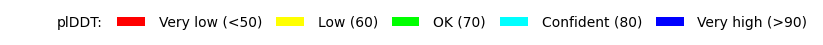

In [46]:
def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt


def plot_confidence(plddt, pae=None, Ls=None, dpi=100):
  use_ptm = False if pae is None else True
  if use_ptm:
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.subplot(1,2,1);
  else:
    plt.figure(figsize=(5,3), dpi=dpi)
  plt.title('Predicted lDDT')
  plt.plot(plddt)
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  if use_ptm:
    plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
    Ln = pae.shape[0]
    plt.imshow(pae,cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.colorbar()
    plt.xlabel('Scored residue')
    plt.ylabel('Aligned residue')
  return plt


plot_plddt_legend()

In [48]:
import py3Dmol

# for i in range(len(pdb_strs)):
for i in range(0,10): 
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(pdb_strs[i])
    
    # Apply the plDDT color scheme
    # view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    
    # # Add surface representation with plDDT-based color
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}})

    view.zoomTo()
    view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [49]:
from plaid.evaluation import RITAPerplexity

perplexity_calc = RITAPerplexity(device=device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
perplexities = perplexity_calc.batch_eval(sequences)

In [51]:
perplexities

18.429670333862305